<a href="https://colab.research.google.com/github/larubiano0/Parcial2-He2AI/blob/main/GDP_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parcial 2 - Inteligencia Artificial

#Datos

##Importación librerías

In [56]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow import keras
from tensorflow.keras import layers
import shap

##Carga base de datos

In [34]:
path = kagglehub.dataset_download("sazidthe1/world-gdp-data")

print("Path to dataset files:", path)
country_codes = pd.read_csv(os.path.join(path, 'country_codes.csv'))
gdp_data = pd.read_csv(os.path.join(path, 'gdp_data.csv'))

Path to dataset files: /root/.cache/kagglehub/datasets/sazidthe1/world-gdp-data/versions/1


##Datos

In [35]:
country_codes.head()

,country_code,region,income_group
0,ABW,Latin America & Caribbean,High income
1,AFG,South Asia,Low income
2,AGO,Sub-Saharan Africa,Lower middle income
3,ALB,Europe & Central Asia,Upper middle income
4,AND,Europe & Central Asia,High income


In [36]:
gdp_data.head()

,country_name,country_code,year,value
0,Afghanistan,AFG,1960,537777811.1
1,Afghanistan,AFG,1961,548888895.6
2,Afghanistan,AFG,1962,546666677.8
3,Afghanistan,AFG,1963,751111191.1
4,Afghanistan,AFG,1964,800000044.4


##Ordenar información

In [37]:
# Transformar la base al formato ancho, manteniendo la columna country_code
gdp_data_pivot = gdp_data.pivot(index=["country_name", "country_code"], columns="year", values="value")

# Opcional: Resetear el índice si deseas que el país sea una columna normal
gdp_data_pivot.reset_index(inplace=True)

# Renombrar indice a index

gdp_data_pivot.rename_axis(None, axis=1, inplace=True)

gdp_data_pivot.head()

,country_name,country_code,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,AFG,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,1.400000e+09,1.673333e+09,...,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
1,Africa Eastern and Southern,AFE,2.112502e+10,2.161623e+10,2.350628e+10,2.804836e+10,2.592067e+10,2.947210e+10,3.201437e+10,3.326951e+10,...,9.860000e+11,1.010000e+12,9.270000e+11,8.850000e+11,1.020000e+12,1.010000e+12,1.000000e+12,9.280000e+11,1.080000e+12,1.170000e+12
2,Africa Western and Central,AFW,1.044764e+10,1.117321e+10,1.199053e+10,1.272769e+10,1.389811e+10,1.492979e+10,1.591084e+10,1.451058e+10,...,8.340000e+11,8.940000e+11,7.690000e+11,6.910000e+11,6.850000e+11,7.670000e+11,8.230000e+11,7.860000e+11,8.440000e+11,8.780000e+11
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.277622e+10,1.322815e+10,1.138685e+10,1.186120e+10,1.301973e+10,1.515642e+10,1.540183e+10,1.516273e+10,1.793057e+10,1.888210e+10
4,Algeria,DZA,2.723615e+09,2.434747e+09,2.001445e+09,2.702982e+09,2.909316e+09,3.136284e+09,3.039859e+09,3.370870e+09,...,2.100000e+11,2.140000e+11,1.660000e+11,1.600000e+11,1.700000e+11,1.750000e+11,1.720000e+11,1.460000e+11,1.630000e+11,1.920000e+11


##Agregar otra base de datos

In [38]:
# Merge gdp_data_pivot with country_codes to add region and income_group columns
gdp_data_pivot = gdp_data_pivot.merge(country_codes, on='country_code', how='left')

# Reorder columns to place region and income_group after country_code
cols = list(gdp_data_pivot.columns)
cols.insert(2, cols.pop(cols.index('region')))
cols.insert(3, cols.pop(cols.index('income_group')))
gdp_data_pivot = gdp_data_pivot[cols]

gdp_data_pivot.head()

,country_name,country_code,region,income_group,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,AFG,South Asia,Low income,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
1,Africa Eastern and Southern,AFE,NaN,NaN,2.112502e+10,2.161623e+10,2.350628e+10,2.804836e+10,2.592067e+10,2.947210e+10,...,9.860000e+11,1.010000e+12,9.270000e+11,8.850000e+11,1.020000e+12,1.010000e+12,1.000000e+12,9.280000e+11,1.080000e+12,1.170000e+12
2,Africa Western and Central,AFW,NaN,NaN,1.044764e+10,1.117321e+10,1.199053e+10,1.272769e+10,1.389811e+10,1.492979e+10,...,8.340000e+11,8.940000e+11,7.690000e+11,6.910000e+11,6.850000e+11,7.670000e+11,8.230000e+11,7.860000e+11,8.440000e+11,8.780000e+11
3,Albania,ALB,Europe & Central Asia,Upper middle income,NaN,NaN,NaN,NaN,NaN,NaN,...,1.277622e+10,1.322815e+10,1.138685e+10,1.186120e+10,1.301973e+10,1.515642e+10,1.540183e+10,1.516273e+10,1.793057e+10,1.888210e+10
4,Algeria,DZA,Middle East & North Africa,Lower middle income,2.723615e+09,2.434747e+09,2.001445e+09,2.702982e+09,2.909316e+09,3.136284e+09,...,2.100000e+11,2.140000e+11,1.660000e+11,1.600000e+11,1.700000e+11,1.750000e+11,1.720000e+11,1.460000e+11,1.630000e+11,1.920000e+11


##Quitar países

In [39]:
# Remove countries that are not countries, i.e. countries that have region NaN, reset index and print the final number of countries

gdp_data_pivot = gdp_data_pivot[gdp_data_pivot['region'].notnull()]
gdp_data_pivot.reset_index(drop=True, inplace=True)
n = len(gdp_data_pivot)
print("Number of countries:", n)
gdp_data_pivot.head()

Number of countries: 214


,country_name,country_code,region,income_group,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,AFG,South Asia,Low income,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
1,Albania,ALB,Europe & Central Asia,Upper middle income,NaN,NaN,NaN,NaN,NaN,NaN,...,1.277622e+10,1.322815e+10,1.138685e+10,1.186120e+10,1.301973e+10,1.515642e+10,1.540183e+10,1.516273e+10,1.793057e+10,1.888210e+10
2,Algeria,DZA,Middle East & North Africa,Lower middle income,2.723615e+09,2.434747e+09,2.001445e+09,2.702982e+09,2.909316e+09,3.136284e+09,...,2.100000e+11,2.140000e+11,1.660000e+11,1.600000e+11,1.700000e+11,1.750000e+11,1.720000e+11,1.460000e+11,1.630000e+11,1.920000e+11
3,American Samoa,ASM,East Asia & Pacific,High income,NaN,NaN,NaN,NaN,NaN,NaN,...,6.380000e+08,6.430000e+08,6.730000e+08,6.710000e+08,6.120000e+08,6.390000e+08,6.470000e+08,7.160000e+08,7.090000e+08,NaN
4,Andorra,AND,Europe & Central Asia,High income,NaN,NaN,NaN,NaN,NaN,NaN,...,3.193513e+09,3.271686e+09,2.789881e+09,2.896610e+09,3.000162e+09,3.218420e+09,3.155149e+09,2.891001e+09,3.325145e+09,3.352033e+09


##Gráficar missing values

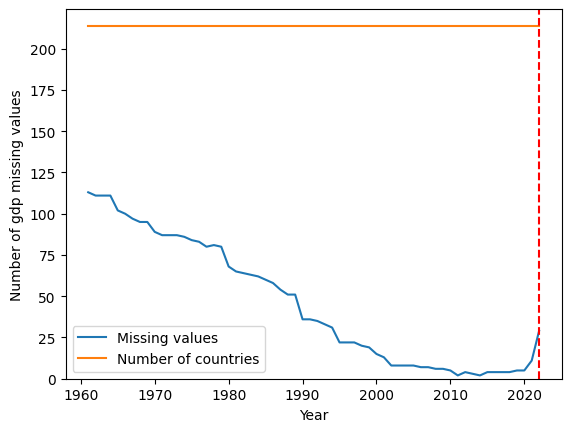

In [40]:
nan_counts_per_year = gdp_data_pivot.isna().sum().tolist()[5:]
plt.ylim(0, n+10)

plt.plot(gdp_data_pivot.columns[5:], nan_counts_per_year)
plt.xlabel('Year')
plt.ylabel('Number of gdp missing values')
plt.plot(gdp_data_pivot.columns[5:], [n] * len(gdp_data_pivot.columns[5:]))
plt.axvline(x=2022, color='r', linestyle='--')
plt.legend(['Missing values', 'Number of countries'])

##Borrar años con varios missing values

In [41]:
# Drop columns 1961 to 1989

gdp_data_pivot.drop(gdp_data_pivot.columns[4:34], axis=1, inplace=True)
gdp_data_pivot

,country_name,country_code,region,income_group,1990,1991,1992,1993,1994,1995,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,AFG,South Asia,Low income,NaN,NaN,NaN,NaN,NaN,NaN,...,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
1,Albania,ALB,Europe & Central Asia,Upper middle income,2.028554e+09,1.099559e+09,6.521750e+08,1.185315e+09,1.880951e+09,2.392765e+09,...,1.277622e+10,1.322815e+10,1.138685e+10,1.186120e+10,1.301973e+10,1.515642e+10,1.540183e+10,1.516273e+10,1.793057e+10,1.888210e+10
2,Algeria,DZA,Middle East & North Africa,Lower middle income,6.204851e+10,4.571568e+10,4.800313e+10,4.994559e+10,4.254318e+10,4.176429e+10,...,2.100000e+11,2.140000e+11,1.660000e+11,1.600000e+11,1.700000e+11,1.750000e+11,1.720000e+11,1.460000e+11,1.630000e+11,1.920000e+11
3,American Samoa,ASM,East Asia & Pacific,High income,NaN,NaN,NaN,NaN,NaN,NaN,...,6.380000e+08,6.430000e+08,6.730000e+08,6.710000e+08,6.120000e+08,6.390000e+08,6.470000e+08,7.160000e+08,7.090000e+08,NaN
4,Andorra,AND,Europe & Central Asia,High income,1.028989e+09,1.106891e+09,1.209993e+09,1.007091e+09,1.017545e+09,1.178745e+09,...,3.193513e+09,3.271686e+09,2.789881e+09,2.896610e+09,3.000162e+09,3.218420e+09,3.155149e+09,2.891001e+09,3.325145e+09,3.352033e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,Virgin Islands (U.S.),VIR,Latin America & Caribbean,High income,NaN,NaN,NaN,NaN,NaN,NaN,...,3.738000e+09,3.565000e+09,3.663000e+09,3.798000e+09,3.794000e+09,3.922000e+09,4.117000e+09,4.204000e+09,NaN,NaN
210,West Bank and Gaza,PSE,Middle East & North Africa,Upper middle income,NaN,NaN,NaN,NaN,2.843300e+09,3.282800e+09,...,1.351550e+10,1.398970e+10,1.397240e+10,1.540540e+10,1.612800e+10,1.627660e+10,1.713350e+10,1.553170e+10,1.810900e+10,1.911190e+10
211,"Yemen, Rep.",YEM,Middle East & North Africa,Low income,5.647119e+09,5.930370e+09,6.463650e+09,5.368271e+09,4.167356e+09,4.258789e+09,...,4.041523e+10,4.322859e+10,4.244449e+10,3.131782e+10,2.684223e+10,2.160616e+10,NaN,NaN,NaN,NaN
212,Zambia,ZMB,Sub-Saharan Africa,Lower middle income,3.285217e+09,3.376807e+09,3.181922e+09,3.273508e+09,3.656808e+09,3.806983e+09,...,2.803724e+10,2.714102e+10,2.125122e+10,2.095841e+10,2.587360e+10,2.631151e+10,2.330867e+10,1.811064e+10,2.214765e+10,2.978445e+10


##Agregar expectativa de vida a los datos

In [42]:
path = kagglehub.dataset_download("iamsouravbanerjee/life-expectancy-at-birth-across-the-globe")
print("Path to dataset files:", path)
life_expectancy = pd.read_csv(os.path.join(path, 'Life Expectancy at Birth.csv'))
life_expectancy.head()

Path to dataset files: /root/.cache/kagglehub/datasets/iamsouravbanerjee/life-expectancy-at-birth-across-the-globe/versions/2


,ISO3,Country,Continent,Hemisphere,Human Development Groups,UNDP Developing Regions,HDI Rank (2021),Life Expectancy at Birth (1990),Life Expectancy at Birth (1991),Life Expectancy at Birth (1992),...,Life Expectancy at Birth (2012),Life Expectancy at Birth (2013),Life Expectancy at Birth (2014),Life Expectancy at Birth (2015),Life Expectancy at Birth (2016),Life Expectancy at Birth (2017),Life Expectancy at Birth (2018),Life Expectancy at Birth (2019),Life Expectancy at Birth (2020),Life Expectancy at Birth (2021)
0,AFG,Afghanistan,Asia,Northern Hemisphere,Low,SA,180.0,45.9672,46.6631,47.5955,...,61.9230,62.4167,62.5451,62.6587,63.1361,63.0160,63.0810,63.5645,62.5751,61.9824
1,AGO,Angola,Africa,Southern Hemisphere,Medium,SSA,148.0,41.8933,43.8127,42.2088,...,58.6231,59.3074,60.0397,60.6546,61.0923,61.6798,62.1438,62.4484,62.2612,61.6434
2,ALB,Albania,Europe,Northern Hemisphere,High,ECA,67.0,73.1439,73.3776,73.7148,...,78.0640,78.1226,78.4075,78.6441,78.8602,79.0473,79.1838,79.2825,76.9893,76.4626
3,AND,Andorra,Europe,Northern Hemisphere,Very High,NaN,40.0,78.4063,77.9805,80.3241,...,82.9166,82.9343,82.9483,82.9534,82.9671,82.9803,82.9923,83.0039,79.0234,80.3684
4,ARE,United Arab Emirates,Asia,Northern Hemisphere,Very High,AS,26.0,71.9004,72.2414,72.3062,...,78.7155,78.8528,79.0442,79.2232,79.3347,79.5036,79.6274,79.7262,78.9457,78.7104


##Ordenar información

In [43]:
# Merge gdp_data_pivot with life_expectancy to add the required columns
gdp_data_pivot = gdp_data_pivot.merge(life_expectancy, left_on='country_code', right_on='ISO3', how='left')

# Define the columns to be added
additional_columns = ["Continent", "Hemisphere", "Human Development Groups", "HDI Rank (2021)"]
life_expectancy_columns = [f"Life Expectancy at Birth ({year})" for year in range(1990, 2022)]

# Reorder columns to place the additional columns after income_group
cols = list(gdp_data_pivot.columns)
for col in additional_columns:
    cols.insert(cols.index('income_group') + 1, cols.pop(cols.index(col)))

# Reorder columns to place the life expectancy columns after each corresponding year
for year in range(1990, 2022):
    cols.insert(cols.index(year) + 1, cols.pop(cols.index(f"Life Expectancy at Birth ({year})")))

# Apply the new column order to the dataframe
gdp_data_pivot = gdp_data_pivot[cols]

#Drop the last 3 columns
gdp_data_pivot.drop(gdp_data_pivot.columns[-3:], axis=1, inplace=True)

gdp_data_pivot

,country_name,country_code,region,income_group,HDI Rank (2021),Human Development Groups,Hemisphere,Continent,1990,Life Expectancy at Birth (1990),...,Life Expectancy at Birth (2017),2018,Life Expectancy at Birth (2018),2019,Life Expectancy at Birth (2019),2020,Life Expectancy at Birth (2020),2021,Life Expectancy at Birth (2021),2022
0,Afghanistan,AFG,South Asia,Low income,180.0,Low,Northern Hemisphere,Asia,NaN,45.9672,...,63.0160,1.841886e+10,63.0810,1.890450e+10,63.5645,2.014345e+10,62.5751,1.458314e+10,61.9824,NaN
1,Albania,ALB,Europe & Central Asia,Upper middle income,67.0,High,Northern Hemisphere,Europe,2.028554e+09,73.1439,...,79.0473,1.515642e+10,79.1838,1.540183e+10,79.2825,1.516273e+10,76.9893,1.793057e+10,76.4626,1.888210e+10
2,Algeria,DZA,Middle East & North Africa,Lower middle income,91.0,High,Northern Hemisphere,Africa,6.204851e+10,67.4160,...,75.7428,1.750000e+11,76.0656,1.720000e+11,76.4742,1.460000e+11,74.4528,1.630000e+11,76.3767,1.920000e+11
3,American Samoa,ASM,East Asia & Pacific,High income,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.390000e+08,NaN,6.470000e+08,NaN,7.160000e+08,NaN,7.090000e+08,NaN,NaN
4,Andorra,AND,Europe & Central Asia,High income,40.0,Very High,Northern Hemisphere,Europe,1.028989e+09,78.4063,...,82.9803,3.218420e+09,82.9923,3.155149e+09,83.0039,2.891001e+09,79.0234,3.325145e+09,80.3684,3.352033e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,Virgin Islands (U.S.),VIR,Latin America & Caribbean,High income,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.922000e+09,NaN,4.117000e+09,NaN,4.204000e+09,NaN,NaN,NaN,NaN
210,West Bank and Gaza,PSE,Middle East & North Africa,Upper middle income,106.0,High,Northern Hemisphere,Asia,NaN,67.9337,...,74.8329,1.627660e+10,74.7930,1.713350e+10,75.2406,1.553170e+10,74.4035,1.810900e+10,73.4727,1.911190e+10
211,"Yemen, Rep.",YEM,Middle East & North Africa,Low income,183.0,Low,Northern Hemisphere,Asia,5.647119e+09,58.6994,...,65.9573,2.160616e+10,64.5751,NaN,65.0917,NaN,64.6501,NaN,63.7534,NaN
212,Zambia,ZMB,Sub-Saharan Africa,Lower middle income,154.0,Medium,Southern Hemisphere,Africa,3.285217e+09,47.9263,...,62.1201,2.631151e+10,62.3422,2.330867e+10,62.7926,1.811064e+10,62.3803,2.214765e+10,61.2234,2.978445e+10


In [44]:
unique_income_group = gdp_data_pivot['income_group'].unique()
unique_human_development_groups = gdp_data_pivot['Human Development Groups'].unique()
unique_hemisphere = gdp_data_pivot['Hemisphere'].unique()
unique_continent = gdp_data_pivot['Continent'].unique()
unique_region = gdp_data_pivot['region'].unique()

print("Unique values for income_group:", unique_income_group)
print("Unique values for Human Development Groups:", unique_human_development_groups)
print("Unique values for Hemisphere:", unique_hemisphere)
print("Unique values for Continent:", unique_continent)
print("Unique values for Region:", unique_region)

Unique values for income_group: ['Low income' 'Upper middle income' 'Lower middle income' 'High income']
Unique values for Human Development Groups: ['Low' 'High' nan 'Very High' 'Medium']
Unique values for Hemisphere: ['Northern Hemisphere' nan 'Southern Hemisphere']
Unique values for Continent: ['Asia' 'Europe' 'Africa' nan 'America' 'Oceania']
Unique values for Region: ['South Asia' 'Europe & Central Asia' 'Middle East & North Africa'
 'East Asia & Pacific' 'Sub-Saharan Africa' 'Latin America & Caribbean'
 'North America']


In [45]:
# Interpolate GDP data
gdp_columns = list(range(1990, 2023))
# First, interpolate as before:
gdp_data_pivot[gdp_columns] = gdp_data_pivot[gdp_columns].interpolate(axis=1, limit_direction='both')

# Then fill any remaining NaNs using forward fill and backward fill:
gdp_data_pivot[gdp_columns] = gdp_data_pivot[gdp_columns].fillna(method='ffill').fillna(method='bfill')


# Interpolate Life Expectancy at Birth data
gdp_data_pivot[life_expectancy_columns] = gdp_data_pivot[life_expectancy_columns].interpolate(axis=1, limit_direction='both')
gdp_data_pivot[life_expectancy_columns] = gdp_data_pivot[life_expectancy_columns].fillna(method='ffill').fillna(method='bfill')

# Display the updated dataframe
gdp_data_pivot.head()

<ipython-input-45-fe03c7d9dc03>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_data_pivot[gdp_columns] = gdp_data_pivot[gdp_columns].fillna(method='ffill').fillna(method='bfill')
<ipython-input-45-fe03c7d9dc03>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_data_pivot[life_expectancy_columns] = gdp_data_pivot[life_expectancy_columns].fillna(method='ffill').fillna(method='bfill')


,country_name,country_code,region,income_group,HDI Rank (2021),Human Development Groups,Hemisphere,Continent,1990,Life Expectancy at Birth (1990),...,Life Expectancy at Birth (2017),2018,Life Expectancy at Birth (2018),2019,Life Expectancy at Birth (2019),2020,Life Expectancy at Birth (2020),2021,Life Expectancy at Birth (2021),2022
0,Afghanistan,AFG,South Asia,Low income,180.0,Low,Northern Hemisphere,Asia,3.854235e+09,45.9672,...,63.0160,1.841886e+10,63.0810,1.890450e+10,63.5645,2.014345e+10,62.5751,1.458314e+10,61.9824,1.458314e+10
1,Albania,ALB,Europe & Central Asia,Upper middle income,67.0,High,Northern Hemisphere,Europe,2.028554e+09,73.1439,...,79.0473,1.515642e+10,79.1838,1.540183e+10,79.2825,1.516273e+10,76.9893,1.793057e+10,76.4626,1.888210e+10
2,Algeria,DZA,Middle East & North Africa,Lower middle income,91.0,High,Northern Hemisphere,Africa,6.204851e+10,67.4160,...,75.7428,1.750000e+11,76.0656,1.720000e+11,76.4742,1.460000e+11,74.4528,1.630000e+11,76.3767,1.920000e+11
3,American Samoa,ASM,East Asia & Pacific,High income,NaN,NaN,NaN,NaN,5.120000e+08,67.4160,...,75.7428,6.390000e+08,76.0656,6.470000e+08,76.4742,7.160000e+08,74.4528,7.090000e+08,76.3767,7.090000e+08
4,Andorra,AND,Europe & Central Asia,High income,40.0,Very High,Northern Hemisphere,Europe,1.028989e+09,78.4063,...,82.9803,3.218420e+09,82.9923,3.155149e+09,83.0039,2.891001e+09,79.0234,3.325145e+09,80.3684,3.352033e+09


In [46]:
# Remove the specified columns and replace them with one-hot encoding
columns_to_encode = ['region', 'income_group', 'Human Development Groups', 'Hemisphere', 'Continent']
gdp_data_encoded = pd.get_dummies(gdp_data_pivot, columns=columns_to_encode, dummy_na=True)
gdp_data_encoded.head()

,country_name,country_code,HDI Rank (2021),1990,Life Expectancy at Birth (1990),1991,Life Expectancy at Birth (1991),1992,Life Expectancy at Birth (1992),1993,...,Human Development Groups_nan,Hemisphere_Northern Hemisphere,Hemisphere_Southern Hemisphere,Hemisphere_nan,Continent_Africa,Continent_America,Continent_Asia,Continent_Europe,Continent_Oceania,Continent_nan
0,Afghanistan,AFG,180.0,3.854235e+09,45.9672,3.854235e+09,46.6631,3.854235e+09,47.5955,3.854235e+09,...,False,True,False,False,False,False,True,False,False,False
1,Albania,ALB,67.0,2.028554e+09,73.1439,1.099559e+09,73.3776,6.521750e+08,73.7148,1.185315e+09,...,False,True,False,False,False,False,False,True,False,False
2,Algeria,DZA,91.0,6.204851e+10,67.4160,4.571568e+10,67.6875,4.800313e+10,67.7571,4.994559e+10,...,False,True,False,False,True,False,False,False,False,False
3,American Samoa,ASM,NaN,5.120000e+08,67.4160,5.120000e+08,67.6875,5.120000e+08,67.7571,5.120000e+08,...,True,False,False,True,False,False,False,False,False,True
4,Andorra,AND,40.0,1.028989e+09,78.4063,1.106891e+09,77.9805,1.209993e+09,80.3241,1.007091e+09,...,False,True,False,False,False,False,False,True,False,False


##Gráfica de dispersión

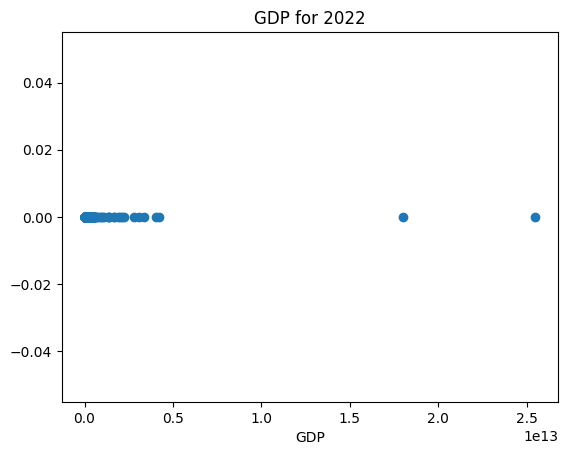

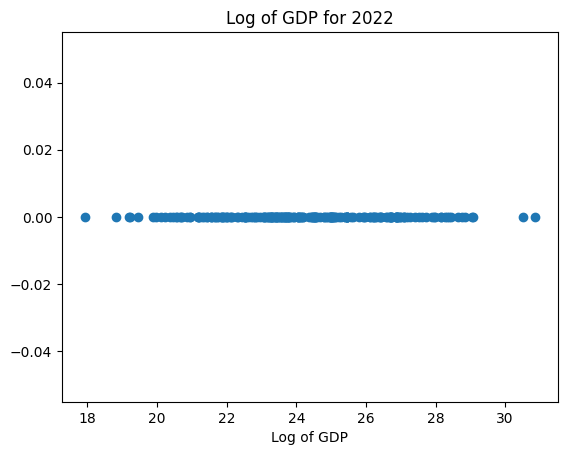

In [47]:
val = 0
ar1 = gdp_data_encoded[2022]
ar2 = np.log(gdp_data_encoded[2022])
plt.title('GDP for 2022')
plt.xlabel('GDP')
plt.plot(ar1, np.zeros_like(ar1) + val, 'o')
plt.show()

plt.title('Log of GDP for 2022')
plt.xlabel('Log of GDP')
plt.plot(ar2, np.zeros_like(ar2) + val, 'o')
plt.show()


##Información final

In [48]:
cols = list(gdp_data_encoded.columns)
cols.append(cols.pop(cols.index(2022)))
gdp_data_encoded = gdp_data_encoded[cols]
# Take the natural logarithm of the GDP for 2022
gdp_data_encoded['ln_gdp_2022'] = np.log(gdp_data_encoded[2022])

# Calculate the thresholds for the lower, middle, and higher thirds
lower_threshold = gdp_data_encoded['ln_gdp_2022'].quantile(1/3)
upper_threshold = gdp_data_encoded['ln_gdp_2022'].quantile(2/3)

# Create the one-hot encoding for the three groups
gdp_data_encoded['gdp_2022_low'] = (gdp_data_encoded['ln_gdp_2022'] <= lower_threshold).astype(int)
gdp_data_encoded['gdp_2022_middle'] = ((gdp_data_encoded['ln_gdp_2022'] > lower_threshold) & (gdp_data_encoded['ln_gdp_2022'] <= upper_threshold)).astype(int)
gdp_data_encoded['gdp_2022_high'] = (gdp_data_encoded['ln_gdp_2022'] > upper_threshold).astype(int)

# Drop the original 2022 column and the ln_gdp_2022 column
gdp_data_encoded.drop(columns=[2022, 'ln_gdp_2022'], inplace=True)

gdp_data_encoded.head()


<ipython-input-48-5749351594c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_data_encoded['ln_gdp_2022'] = np.log(gdp_data_encoded[2022])
<ipython-input-48-5749351594c0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_data_encoded['gdp_2022_low'] = (gdp_data_encoded['ln_gdp_2022'] <= lower_threshold).astype(int)
<ipython-input-48-5749351594c0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,country_name,country_code,HDI Rank (2021),1990,Life Expectancy at Birth (1990),1991,Life Expectancy at Birth (1991),1992,Life Expectancy at Birth (1992),1993,...,Hemisphere_nan,Continent_Africa,Continent_America,Continent_Asia,Continent_Europe,Continent_Oceania,Continent_nan,gdp_2022_low,gdp_2022_middle,gdp_2022_high
0,Afghanistan,AFG,180.0,3.854235e+09,45.9672,3.854235e+09,46.6631,3.854235e+09,47.5955,3.854235e+09,...,False,False,False,True,False,False,False,0,1,0
1,Albania,ALB,67.0,2.028554e+09,73.1439,1.099559e+09,73.3776,6.521750e+08,73.7148,1.185315e+09,...,False,False,False,False,True,False,False,0,1,0
2,Algeria,DZA,91.0,6.204851e+10,67.4160,4.571568e+10,67.6875,4.800313e+10,67.7571,4.994559e+10,...,False,True,False,False,False,False,False,0,0,1
3,American Samoa,ASM,NaN,5.120000e+08,67.4160,5.120000e+08,67.6875,5.120000e+08,67.7571,5.120000e+08,...,True,False,False,False,False,False,True,1,0,0
4,Andorra,AND,40.0,1.028989e+09,78.4063,1.106891e+09,77.9805,1.209993e+09,80.3241,1.007091e+09,...,False,False,False,False,True,False,False,1,0,0


#Red neuronal

##Separar variables y "arreglar" errores

In [49]:
# Separar características y variable objetivo
X = gdp_data_encoded.drop(columns=['gdp_2022_low', 'gdp_2022_middle', 'gdp_2022_high'])
y = gdp_data_encoded[['gdp_2022_low', 'gdp_2022_middle', 'gdp_2022_high']]

# Convertir la variable objetivo en una sola etiqueta categórica
y = y.idxmax(axis=1).map({'gdp_2022_low': 0, 'gdp_2022_middle': 1, 'gdp_2022_high': 2})

# Asegurar que todas las columnas sean numéricas
X = pd.get_dummies(X, drop_first=True)

# Reemplazar NaN con la media de cada columna
X = X.fillna(X.mean())

# Convertir nombres de columnas a strings
X.columns = X.columns.astype(str)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##Modelo y entrenamiento

In [60]:
# Definir el modelo base
perceptron = MLPClassifier(
    hidden_layer_sizes=(50,),  # Una capa oculta con 3 neuronas
    activation='logistic',    # Función de activación sigmoide
    solver='sgd',            # Descenso de gradiente estocástico
    max_iter=500,           # Máximo número de iteraciones
    alpha=0.01,
    random_state=42
)

# Entrenar el modelo
perceptron.fit(X_train_scaled, y_train)

# Evaluar el modelo
y_pred = perceptron.predict(X_test_scaled)
y_pred_prob = perceptron.predict_proba(X_test_scaled)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Búsqueda de hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'alpha': [0.0001, 0.01, 0.1],
    'max_iter': [500, 1000]
}

grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Mejor modelo
best_mlp = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

Accuracy: 0.5581395348837209
              precision    recall  f1-score   support

           0       0.50      0.67      0.57        15
           1       0.50      0.43      0.46        14
           2       0.73      0.57      0.64        14

    accuracy                           0.56        43
   macro avg       0.58      0.56      0.56        43
weighted avg       0.57      0.56      0.56        43



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Mejores hiperparámetros: {'alpha': 0.1, 'hidden_layer_sizes': (50,), 'max_iter': 500}


##Gráficos

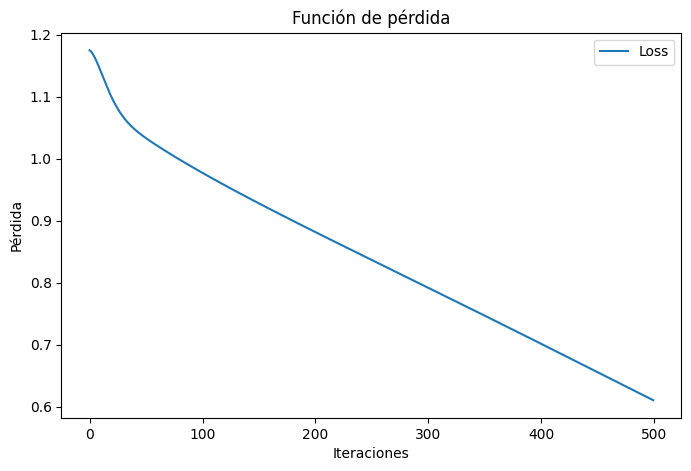

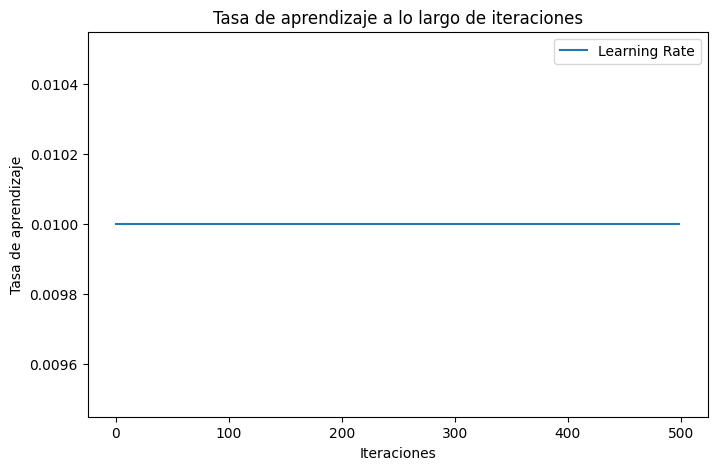

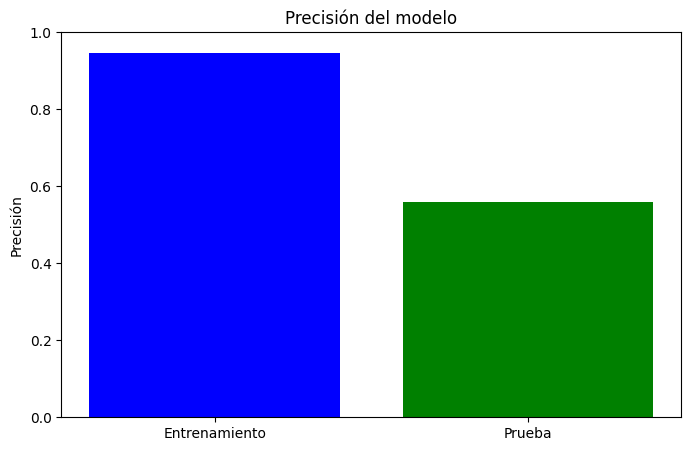

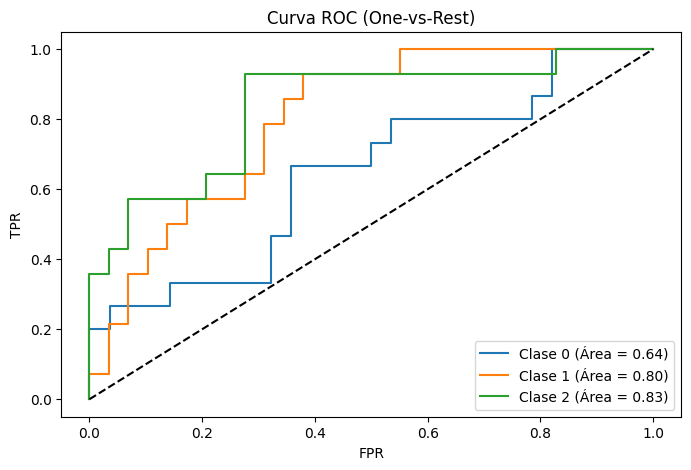

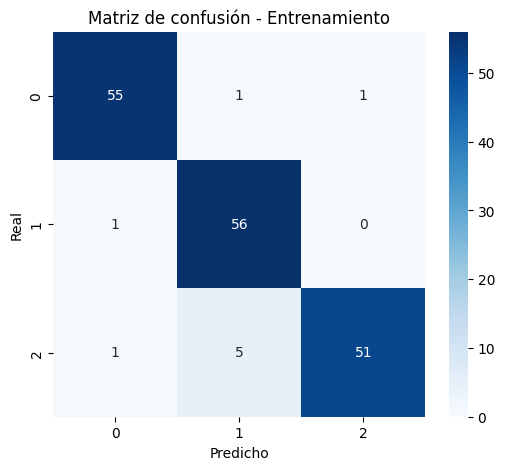

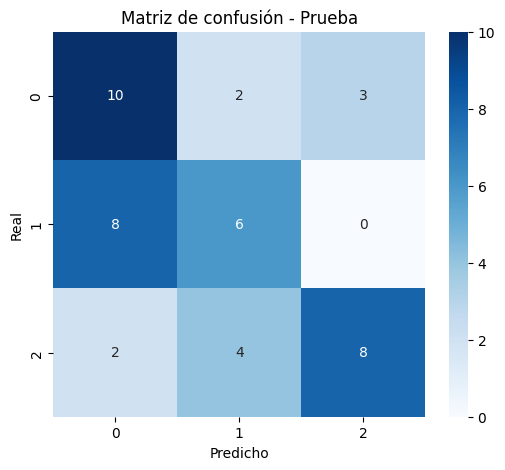

In [62]:
# Graficar la función de pérdida
plt.figure(figsize=(8, 5))
plt.plot(perceptron.loss_curve_, label='Loss')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.title('Función de pérdida')
plt.legend()
plt.show()

# Graficar la tasa de aprendizaje (como un valor constante)
plt.figure(figsize=(8, 5))
learning_rate = 0.01  # Valor definido en el modelo (alpha)
plt.plot(np.arange(len(perceptron.loss_curve_)), [learning_rate] * len(perceptron.loss_curve_), label='Learning Rate')
plt.xlabel('Iteraciones')
plt.ylabel('Tasa de aprendizaje')
plt.title('Tasa de aprendizaje a lo largo de iteraciones')
plt.legend()
plt.show()

# Graficar la precisión del modelo
y_train_pred = perceptron.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)
plt.figure(figsize=(8, 5))
plt.bar(['Entrenamiento', 'Prueba'], [train_acc, test_acc], color=['blue', 'green'])
plt.ylabel('Precisión')
plt.title('Precisión del modelo')
plt.ylim([0, 1])
plt.show()

# Binarizar y_test para que tenga formato one-hot
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Graficar la curva ROC para cada clase
plt.figure(figsize=(8, 5))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])  # Usa la probabilidad correcta
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (Área = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC (One-vs-Rest)')
plt.legend()
plt.show()

# Graficar la matriz de confusión
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_train, perceptron.predict(X_train_scaled), 'Matriz de confusión - Entrenamiento')
plot_conf_matrix(y_test, y_pred, 'Matriz de confusión - Prueba')